Imports

In [1]:
#!pip install tensorboardX

In [2]:
import torch
import argparse
import logging
#from tensorboardX import SummaryWriter
import os
import numpy as np

from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset
import random
from re import split
import torch.utils.data

# import torch.nn as nn
from collections import OrderedDict

import functools
from torch.nn import init
from torch.nn import modules

# u-net
import math
import torch.nn.functional as F
from inspect import isfunction

# diffusion
from torch import nn
from functools import partial
from tqdm import tqdm

Config

In [ ]:
opt = {
    "name": "denoising",
    "phase": "train", # train or test (or val?? -> what is phase even used for also?)
    "gpu_ids": [0, 1], 
    "debug": False,  
    "enable_wandb": False,  
    "log_wandb_ckpt": False,  
    "log_eval": False,  
    "path": {
        "log": "/kaggle/working/logs",
        "tb_logger": "/kaggle/working/tb_logger",
        "results": "/kaggle/working/results",
        "checkpoint": "/kaggle/working/checkpoint",
        "resume_state": None
    },
    "datasets": {
        "train": {
            "noisy_data_paths": ['/kaggle/input/fmri-train-1-normalized/data/noisy_func_train_1.npy',
                '/kaggle/input/fmri-train-2-normalized/data/noisy_func_train_2.npy',
                '/kaggle/input/fmri-train-3-normalized/data/noisy_func_train_3.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-train-1-normalized/data/gt_func_train_1.npy',
                '/kaggle/input/fmri-train-2-normalized/data/gt_func_train_2.npy',
                '/kaggle/input/fmri-train-3-normalized/data/gt_func_train_3.npy'],
            "batch_size": 1,
            "num_workers": 1,
            "use_shuffle": True
        },
        "test": {
            "noisy_data_paths": ['/kaggle/input/fmri-test/data/noisy_func_test.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-test/data/gt_func_test.npy']
        }
    },
    "model": {
        "which_model_G": "sr3",
        "finetune_norm": False,
        "unet": {
            "in_channel": 2,
            "out_channel": 1,
            "inner_channel": 64,
            "norm_groups": 16,
            "channel_multiplier": [1, 2, 4, 8],
            "attn_res": [],
            "res_blocks": 1,
            "dropout": 0
        },
        "beta_schedule": {
            "train": {
                "schedule": "linear",
                "n_timestep": 2000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            },
            "test": {
                "schedule": "linear",
                "n_timestep": 2000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            }
        },
        "diffusion": {
            "image_size": 64,
            "channels": 1,
            "conditional": True
        }
    },
    "train": {
        "n_iter": 27000,
        "val_freq": 1e4,
        "save_checkpoint_freq": 21600,
        "print_freq": 100,
        "optimizer": {
            "type": "adam",
            "lr": 3e-4
        },
        "ema_scheduler": {
            "step_start_ema": 22500,
            "update_ema_every": 1,
            "ema_decay": 0.996
        }
    },
    "wandb": {
        "project": "distributed_high_sr_ffhq"
    },
    "config_file": "config/sr_sr3_16_128.json"  # from CLI
}

In [4]:
os.makedirs(opt['path']['log'], exist_ok=True)
os.makedirs(opt['path']['tb_logger'], exist_ok=True)
os.makedirs(opt['path']['results'], exist_ok=True)
os.makedirs(opt['path']['checkpoint'], exist_ok=True)
#os.makedirs(opt['path']['resume_state'], exist_ok=True)

Logger

In [5]:
# logging
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

def dict2str(opt, indent_l=1):
    '''dict to string for logger'''
    msg = ''
    for k, v in opt.items():
        if isinstance(v, dict):
            msg += ' ' * (indent_l * 2) + k + ':[\n'
            msg += dict2str(v, indent_l + 1)
            msg += ' ' * (indent_l * 2) + ']\n'
        else:
            msg += ' ' * (indent_l * 2) + k + ': ' + str(v) + '\n'
    return msg

def setup_logger(logger_name, root, phase, level=logging.INFO, screen=False):
    '''set up logger'''
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter(
        '%(asctime)s.%(msecs)03d - %(levelname)s: %(message)s', datefmt='%y-%m-%d %H:%M:%S')
    log_file = os.path.join(root, '{}.log'.format(phase))
    fh = logging.FileHandler(log_file, mode='w')
    fh.setFormatter(formatter)
    l.setLevel(level)
    l.addHandler(fh)
    if screen:
        sh = logging.StreamHandler()
        sh.setFormatter(formatter)
        l.addHandler(sh)


setup_logger(None, opt['path']['log'],
                    'train', level=logging.INFO, screen=True)
setup_logger('val', opt['path']['log'], 'val', level=logging.INFO)
logger = logging.getLogger('base')
#logger.info(dict2str(opt))
#tb_logger = SummaryWriter(log_dir=opt['path']['tb_logger'])

# # Initialize WandbLogger
# if opt['enable_wandb']:
#     import wandb
#     wandb_logger = WandbLogger(opt)
#     wandb.define_metric('validation/val_step')
#     wandb.define_metric('epoch')
#     wandb.define_metric("validation/*", step_metric="val_step")
#     val_step = 0
# else:
#     wandb_logger = None

Dataset creation

In [6]:
class PairwiseDataset(Dataset):
    def __init__(self, noisy_images_paths: list, gt_images_paths: list):
        """Initialize fMRI dataset for denoising with memory-efficient loading.
        
        Args:
            noisy_images_paths (list): List of paths to noisy fMRI volumes (.npy files)
            gt_images_paths (list): List of paths to ground truth fMRI volumes (.npy files)
        """
        self.noisy_paths = noisy_images_paths
        self.gt_paths = gt_images_paths
        
        # Get the data shape and total slices without loading all data
        # Just load file info and calculate indices
        self.file_slice_mapping = []
        self.z_t_dimension_sizes = []
        total_slices = 0
        dataset_length = 0 # in terms of indeces that can be iteratet over at the end (less than slice number due to batch loading within get_item)
        
        for i, path in enumerate(noisy_images_paths):
            # Load metadata about the file shape without loading full content
            data_shape = np.load(path, mmap_mode='r').shape
            num_slices = data_shape[2] * data_shape[3]  # z * t
            self.z_t_dimension_sizes.append((data_shape[2], data_shape[3]))
            
            # Store mapping information: which file and which t index (has been done due to more efficient data loading, no information aggregation based thinking behind that)
            for batch_idx in range(0, data_shape[3]):
                self.file_slice_mapping.append((i, batch_idx))
                dataset_length += 1
            
            total_slices += num_slices 
            
        self.data_len = dataset_length

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        # Use the mapping to determine which file and slice to load
        file_idx, t_idx = self.file_slice_mapping[index]
        
        # Load data from the specific file
        noisy_file_path = self.noisy_paths[file_idx]
        gt_file_path = self.gt_paths[file_idx]
        
        # Load the full 4D array with mmap_mode to avoid loading everything
        noisy_volume = np.load(noisy_file_path, mmap_mode='r')
        gt_volume = np.load(gt_file_path, mmap_mode='r')
        
        # Extract only the slice we need
        noisy_slice = noisy_volume[:, :, :, t_idx].copy()  # Force copy from mmap
        gt_slice = gt_volume[:, :, :, t_idx].copy()
        
        return {
            'GT': torch.tensor(gt_slice).float().unsqueeze(0).permute(-1, 0, 1, 2),
            'Noisy': torch.tensor(noisy_slice).float().unsqueeze(0).permute(-1, 0, 1, 2),
            'Index': index
        }

In [7]:
def collate_merge_batches(batch):
    merged = {
        'Noisy': torch.cat([item['Noisy'] for item in batch], dim=0),
        'GT': torch.cat([item['GT'] for item in batch], dim=0),
        'Index': [item['Index'] for item in batch]
    }
    return merged

def create_dataloader(dataset, dataset_opt, phase):
    '''create dataloader '''
    if phase == 'train':
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=dataset_opt['batch_size'],
            shuffle=dataset_opt['use_shuffle'],
            num_workers=dataset_opt['num_workers'],
            pin_memory=True,
            collate_fn = collate_merge_batches)
    elif phase == 'test':
        return torch.utils.data.DataLoader(
            dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True, collate_fn = lambda x: x[0])
    else:
        raise NotImplementedError(
            'Dataloader [{:s}] is not found.'.format(phase))

In [8]:
# dataset
for phase, dataset_opt in opt['datasets'].items():
    if phase == 'train' and opt['phase'] != 'test':
        train_set = PairwiseDataset(dataset_opt['noisy_data_paths'], dataset_opt['gt_data_paths'])
        train_loader = create_dataloader(
            train_set, dataset_opt, phase)
    elif phase == 'test':
        test_set = PairwiseDataset(dataset_opt['noisy_data_paths'], dataset_opt['gt_data_paths'])
        test_loader = create_dataloader(
            test_set, dataset_opt, phase)
# logger.info('Initial Dataset Finished')

In [9]:
noisy_slice = train_set[400]["Noisy"]
gt_slice = train_set[400]["GT"]

In [10]:
# for _, data in train_loader:
#     print(data.shape)

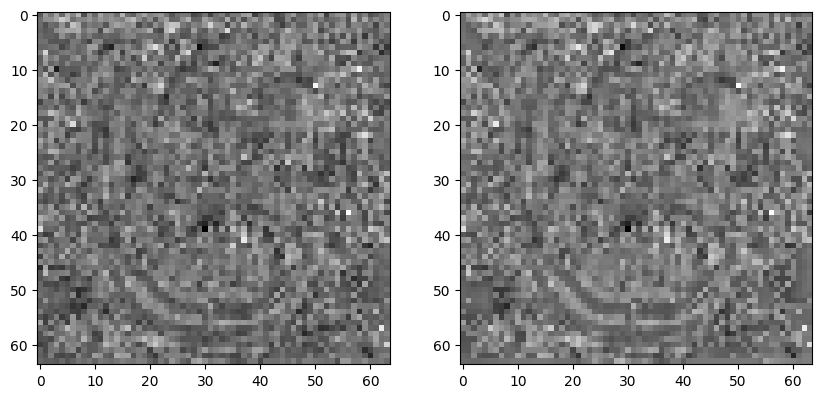

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth image
axes[0].imshow(noisy_slice[0,0,:,:], cmap='gray')
axes[1].imshow(gt_slice[0,0,:,:], cmap='gray')

## Model loading

Modules

In [12]:
# generic functions
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

In [13]:
### U-Net ###

# PositionalEncoding Source： https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype,
                            device=noise_level.device) / count
        encoding = noise_level.unsqueeze(
            1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat(
            [torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(
                batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32):
        super().__init__()
        self.noise_func = FeatureWiseAffine(
            noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum(
            "bnchw, bncyx -> bnhwyx", query, key
        ).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=32,
        channel_mults=(1, 2, 4, 8, 8),
        attn_res=(8),
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=128
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)

In [ ]:
import torch

In [ ]:
### Diffusion ###
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


# gaussian diffusion trainer class
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        image_size,
        channels=3,
        loss_type='l1',
        conditional=True,
        schedule_opt=None
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn
        self.loss_type = loss_type
        self.conditional = conditional
        if schedule_opt is not None:
            pass
            # self.set_new_noise_schedule(schedule_opt)

    def set_loss(self, device):
        if self.loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum').to(device)
        elif self.loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum').to(device)
        else:
            raise NotImplementedError()

    def set_new_noise_schedule(self, schedule_opt, device):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

        betas = make_beta_schedule(
            schedule=schedule_opt['schedule'],
            n_timestep=schedule_opt['n_timestep'],
            linear_start=schedule_opt['linear_start'],
            linear_end=schedule_opt['linear_end'])
        betas = betas.detach().cpu().numpy() if isinstance(
            betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(
            np.append(1., alphas_cumprod))

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev',
                             to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod',
                             to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod',
                             to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod',
                             to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * \
            (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance',
                             to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(
            np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def predict_start_from_noise(self, x_t, t, noise):
        return self.sqrt_recip_alphas_cumprod[t] * x_t - \
            self.sqrt_recipm1_alphas_cumprod[t] * noise

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * \
            x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor(
            [self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size, 1).to(x.device)
        if condition_x is not None:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(torch.cat([condition_x, x], dim=1), noise_level))
        else:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(x, noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None):
        model_mean, model_log_variance = self.p_mean_variance(
            x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def p_sample_loop(self, x_in, continous=False):
        device = self.betas.device
        sample_inter = (1 | (self.num_timesteps//10))
        if not self.conditional:
            shape = x_in
            img = torch.randn(shape, device=device)
            ret_img = img
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        else:
            x = x_in
            shape = x.shape
            img = torch.randn(shape, device=device)
            ret_img = x
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i, condition_x=x)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        if continous:
            return ret_img
        else:
            return ret_img[-1]

    @torch.no_grad()
    def sample(self, batch_size=1, continous=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size), continous)

    @torch.no_grad()
    def super_resolution(self, x_in, continous=False):
        return self.p_sample_loop(x_in, continous)

    def q_sample(self, x_start, continuous_sqrt_alpha_cumprod, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        # random gama
        return (
            continuous_sqrt_alpha_cumprod * x_start +
            (1 - continuous_sqrt_alpha_cumprod**2).sqrt() * noise
        )

    def p_losses(self, x_in, noise=None):
        x_start = x_in['GT']
        [b, c, h, w] = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        continuous_sqrt_alpha_cumprod = torch.FloatTensor(
            np.random.uniform(
                self.sqrt_alphas_cumprod_prev[t-1],
                self.sqrt_alphas_cumprod_prev[t],
                size=b
            )
        ).to(x_start.device)
        continuous_sqrt_alpha_cumprod = continuous_sqrt_alpha_cumprod.view(
            b, -1)

        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(
            x_start=x_start, continuous_sqrt_alpha_cumprod=continuous_sqrt_alpha_cumprod.view(-1, 1, 1, 1), noise=noise)

        if not self.conditional:
            x_recon = self.denoise_fn(x_noisy, continuous_sqrt_alpha_cumprod)
        else:
            x_recon = self.denoise_fn(
                torch.cat([x_in['Noisy'], x_noisy], dim=1), continuous_sqrt_alpha_cumprod)
                # Everything has to be 4D! Otherwise concatenation on this axis is not possible!!!
                # The concatenated representation is automatically 4D anyways at the end!!!
        loss = self.loss_func(noise, x_recon)
        return loss

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)

Helper functions

In [15]:
def weights_init_normal(m, std=0.02):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, std)  # BN also uses norm
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m, scale=1):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='kaiming', scale=1, std=0.02):
    # scale for 'kaiming', std for 'normal'.
    logger.info('Initialization method [{:s}]'.format(init_type))
    if init_type == 'normal':
        weights_init_normal_ = functools.partial(weights_init_normal, std=std)
        net.apply(weights_init_normal_)
    elif init_type == 'kaiming':
        weights_init_kaiming_ = functools.partial(
            weights_init_kaiming, scale=scale)
        net.apply(weights_init_kaiming_)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError(
            'initialization method [{:s}] not implemented'.format(init_type))


####################
# define network
####################


# Generator
def define_G(opt):
    model_opt = opt['model']
    if ('norm_groups' not in model_opt['unet']) or model_opt['unet']['norm_groups'] is None:
        model_opt['unet']['norm_groups']=32
    model = UNet(
        in_channel=model_opt['unet']['in_channel'],
        out_channel=model_opt['unet']['out_channel'],
        norm_groups=model_opt['unet']['norm_groups'],
        inner_channel=model_opt['unet']['inner_channel'],
        channel_mults=model_opt['unet']['channel_multiplier'],
        attn_res=model_opt['unet']['attn_res'],
        res_blocks=model_opt['unet']['res_blocks'],
        dropout=model_opt['unet']['dropout'],
        image_size=model_opt['diffusion']['image_size']
    )
    netG = GaussianDiffusion(
        model,
        image_size=model_opt['diffusion']['image_size'],
        channels=model_opt['diffusion']['channels'],
        loss_type='l1',    # L1 or L2
        conditional=model_opt['diffusion']['conditional'],
        schedule_opt=model_opt['beta_schedule']['train']
    )
    if opt['phase'] == 'train':
        # init_weights(netG, init_type='kaiming', scale=0.1)
        init_weights(netG, init_type='orthogonal')
    if opt['gpu_ids']:
        assert torch.cuda.is_available()
    # if opt['gpu_ids'] and opt['distributed']:
    #     assert torch.cuda.is_available()
    #     netG = nn.DataParallel(netG)
    return netG

Model classes

In [16]:
class SR3():
    def __init__(self, opt):       
        self.opt = opt
        self.device = torch.device(
            'cuda' if opt['gpu_ids'] is not None else 'cpu')
        self.begin_step = 0
        self.begin_epoch = 0
        # define network and load pretrained models
        self.netG = self.set_device(define_G(opt))
        self.schedule_phase = None

        # set loss and load resume state
        self.set_loss()
        self.set_new_noise_schedule(
            opt['model']['beta_schedule']['train'], schedule_phase='train')
        if self.opt['phase'] == 'train':
            self.netG.train()
            # find the parameters to optimize
            if opt['model']['finetune_norm']:
                optim_params = []
                for k, v in self.netG.named_parameters():
                    v.requires_grad = False
                    if k.find('transformer') >= 0:
                        v.requires_grad = True
                        v.data.zero_()
                        optim_params.append(v)
                        logger.info(
                            'Params [{:s}] initialized to 0 and will optimize.'.format(k))
            else:
                optim_params = list(self.netG.parameters())

            self.optG = torch.optim.Adam(
                optim_params, lr=opt['train']["optimizer"]["lr"])
            self.log_dict = OrderedDict()
        self.load_network()
        self.print_network()

    def set_device(self, x):
        if isinstance(x, dict):
            for key, item in x.items():
                if item is not None and type(item)==torch.Tensor:
                    x[key] = item.to(self.device)
        elif isinstance(x, list):
            for item in x:
                if item is not None:
                    item = item.to(self.device)
        else:
            x = x.to(self.device)
        return x

    def get_network_description(self, network):
        '''Get the string and total parameters of the network'''
        if isinstance(network, nn.DataParallel):
            network = network.module
        s = str(network)
        n = sum(map(lambda x: x.numel(), network.parameters()))
        return s, n

    def feed_data(self, data):
        self.data = self.set_device(data)

    def optimize_parameters(self):
        self.optG.zero_grad()
        l_pix = self.netG(self.data)
        b, c, h, w = self.data['GT'].shape
        l_pix = l_pix.sum()/int(b*c*h*w)
        l_pix.backward()
        self.optG.step()

        # set log
        self.log_dict['l_pix'] = l_pix.item()

        return l_pix.item()

    def test(self, continous=False):
        self.netG.eval()
        with torch.no_grad():
            if isinstance(self.netG, nn.DataParallel):
                self.SR = self.netG.module.super_resolution(
                    self.data['SR'], continous)
            else:
                self.SR = self.netG.super_resolution(
                    self.data['SR'], continous)
        self.netG.train()

    def sample(self, batch_size=1, continous=False):
        self.netG.eval()
        with torch.no_grad():
            if isinstance(self.netG, nn.DataParallel):
                self.SR = self.netG.module.sample(batch_size, continous)
            else:
                self.SR = self.netG.sample(batch_size, continous)
        self.netG.train()

    def set_loss(self):
        if isinstance(self.netG, nn.DataParallel):
            self.netG.module.set_loss(self.device)
        else:
            self.netG.set_loss(self.device)

    def set_new_noise_schedule(self, schedule_opt, schedule_phase='train'):
        if self.schedule_phase is None or self.schedule_phase != schedule_phase:
            self.schedule_phase = schedule_phase
            if isinstance(self.netG, nn.DataParallel):
                self.netG.module.set_new_noise_schedule(
                    schedule_opt, self.device)
            else:
                self.netG.set_new_noise_schedule(schedule_opt, self.device)

    def get_current_log(self):
        return self.log_dict

    def get_current_visuals(self, need_LR=True, sample=False):
        out_dict = OrderedDict()
        if sample:
            out_dict['SAM'] = self.SR.detach().float().cpu()
        else:
            out_dict['SR'] = self.SR.detach().float().cpu()
            out_dict['INF'] = self.data['SR'].detach().float().cpu()
            out_dict['HR'] = self.data['HR'].detach().float().cpu()
            if need_LR and 'LR' in self.data:
                out_dict['LR'] = self.data['LR'].detach().float().cpu()
            else:
                out_dict['LR'] = out_dict['INF']
        return out_dict

    def print_network(self):
        s, n = self.get_network_description(self.netG)
        if isinstance(self.netG, nn.DataParallel):
            net_struc_str = '{} - {}'.format(self.netG.__class__.__name__,
                                             self.netG.module.__class__.__name__)
        else:
            net_struc_str = '{}'.format(self.netG.__class__.__name__)

        logger.info(
            'Network G structure: {}, with parameters: {:,d}'.format(net_struc_str, n))
        logger.info(s)

    def save_network(self, epoch, iter_step, is_final=False):
        if is_final:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_gen.pth'.format(iter_step, epoch))
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_opt.pth'.format(iter_step, epoch))
        else:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_gen.pth'.format(iter_step, epoch))
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_opt.pth'.format(iter_step, epoch))
        # gen
        network = self.netG
        if isinstance(self.netG, nn.DataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, gen_path)
        # opt
        opt_state = {'epoch': epoch, 'iter': iter_step,
                     'scheduler': None, 'optimizer': None}
        opt_state['optimizer'] = self.optG.state_dict()
        torch.save(opt_state, opt_path)

        logger.info(
            'Saved model in [{:s}] ...'.format(gen_path))

    def load_network(self):
        load_path = self.opt['path']['resume_state']
        if load_path is not None:
            logger.info(
                'Loading pretrained model for G [{:s}] ...'.format(load_path))
            gen_path = '{}_gen.pth'.format(load_path)
            opt_path = '{}_opt.pth'.format(load_path)
            # gen
            network = self.netG
            if isinstance(self.netG, nn.DataParallel):
                network = network.module
            network.load_state_dict(torch.load(
                gen_path), strict=(not self.opt['model']['finetune_norm']))
            # network.load_state_dict(torch.load(
            #     gen_path), strict=False)
            if self.opt['phase'] == 'train':
                # optimizer
                opt = torch.load(opt_path)
                self.optG.load_state_dict(opt['optimizer'])
                self.begin_step = opt['iter']
                self.begin_epoch = opt['epoch']

Training process

In [17]:
# model
diffusion = SR3(opt)
# logger.info('Initial Model Finished')

25-05-13 23:11:20.538 - INFO: Initialization method [orthogonal]
25-05-13 23:11:28.026 - INFO: Network G structure: GaussianDiffusion, with parameters: 38,901,057
25-05-13 23:11:28.027 - INFO: GaussianDiffusion(
  (denoise_fn): UNet(
    (noise_level_mlp): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): Swish()
      (3): Linear(in_features=256, out_features=64, bias=True)
    )
    (downs): ModuleList(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlocWithAttn(
        (res_block): ResnetBlock(
          (noise_func): FeatureWiseAffine(
            (noise_func): Sequential(
              (0): Linear(in_features=64, out_features=64, bias=True)
            )
          )
          (block1): Block(
            (block): Sequential(
              (0): GroupNorm(16, 64, eps=1e-05, affine=True)
              (1): Swish()
              (2): Identity()
              (3): Conv2d(6

In [18]:
# Train
epoch_loss_list = []

current_step = diffusion.begin_step
current_epoch = diffusion.begin_epoch
n_iter = opt['train']['n_iter']

if opt['path']['resume_state']:
    logger.info('Resuming training from epoch: {}, iter: {}.'.format(
        current_epoch, current_step))

diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])
if opt['phase'] == 'train':
    while current_step < n_iter:
        current_epoch += 1
        epoch_loss_values = []
        for _, train_data in enumerate(train_loader):
            current_step += 1
            if current_step > n_iter:
                break
            diffusion.feed_data(train_data)
            current_l_pix = diffusion.optimize_parameters()
            epoch_loss_values.append(current_l_pix)
            # log
            if current_step % opt['train']['print_freq'] == 0:
                logs = diffusion.get_current_log()
                message = '<epoch:{:3d}, iter:{:8,d}> '.format(
                    current_epoch, current_step)
                for k, v in logs.items():
                    message += '{:s}: {:.4e} '.format(k, v)
                    #tb_logger.add_scalar(k, v, current_step)
                logger.info(message)
                
        

                # if wandb_logger:
                #     wandb_logger.log_metrics(logs)

    #         # validation
    #         if current_step % opt['train']['val_freq'] == 0:
    #             avg_psnr = 0.0
    #             idx = 0
    #             result_path = '{}/{}'.format(opt['path']
    #                                             ['results'], current_epoch)
    #             os.makedirs(result_path, exist_ok=True)

    #             diffusion.set_new_noise_schedule(
    #                 opt['model']['beta_schedule']['val'], schedule_phase='val')
    #             for _,  val_data in enumerate(val_loader):
    #                 idx += 1
    #                 diffusion.feed_data(val_data)
    #                 diffusion.test(continous=False)
    #                 visuals = diffusion.get_current_visuals()
    #                 sr_img = Metrics.tensor2img(visuals['SR'])  # uint8
    #                 hr_img = Metrics.tensor2img(visuals['HR'])  # uint8
    #                 lr_img = Metrics.tensor2img(visuals['LR'])  # uint8
    #                 fake_img = Metrics.tensor2img(visuals['INF'])  # uint8

    #                 # generation
    #                 Metrics.save_img(
    #                     hr_img, '{}/{}_{}_hr.png'.format(result_path, current_step, idx))
    #                 Metrics.save_img(
    #                     sr_img, '{}/{}_{}_sr.png'.format(result_path, current_step, idx))
    #                 Metrics.save_img(
    #                     lr_img, '{}/{}_{}_lr.png'.format(result_path, current_step, idx))
    #                 Metrics.save_img(
    #                     fake_img, '{}/{}_{}_inf.png'.format(result_path, current_step, idx))
    #                 tb_logger.add_image(
    #                     'Iter_{}'.format(current_step),
    #                     np.transpose(np.concatenate(
    #                         (fake_img, sr_img, hr_img), axis=1), [2, 0, 1]),
    #                     idx)
    #                 avg_psnr += Metrics.calculate_psnr(
    #                     sr_img, hr_img)

    #                 if wandb_logger:
    #                     wandb_logger.log_image(
    #                         f'validation_{idx}', 
    #                         np.concatenate((fake_img, sr_img, hr_img), axis=1)
    #                     )

    #             avg_psnr = avg_psnr / idx
    #             diffusion.set_new_noise_schedule(
    #                 opt['model']['beta_schedule']['train'], schedule_phase='train')
    #             # log
    #             logger.info('# Validation # PSNR: {:.4e}'.format(avg_psnr))
    #             logger_val = logging.getLogger('val')  # validation logger
    #             logger_val.info('<epoch:{:3d}, iter:{:8,d}> psnr: {:.4e}'.format(
    #                 current_epoch, current_step, avg_psnr))
    #             # tensorboard logger
    #             tb_logger.add_scalar('psnr', avg_psnr, current_step)

    #             if wandb_logger:
    #                 wandb_logger.log_metrics({
    #                     'validation/val_psnr': avg_psnr,
    #                     'validation/val_step': val_step
    #                 })
    #                 val_step += 1
                
            if current_step % opt['train']['save_checkpoint_freq'] == 0:
                logger.info('Saving models and training states.')
                diffusion.save_network(current_epoch, current_step)
            
            if current_step == n_iter:
                logger.info("Saving final model")
                diffusion.save_network(current_epoch, current_step, is_final=True)

                # if wandb_logger and opt['log_wandb_ckpt']:
                #     wandb_logger.log_checkpoint(current_epoch, current_step)

        epoch_loss = sum(epoch_loss_values)/len(epoch_loss_values)
        print('Epoch Loss: ', epoch_loss)
        epoch_loss_list.append(epoch_loss)

        # if wandb_logger:
        #     wandb_logger.log_metrics({'epoch': current_epoch-1})

    # save model
    print('Epoch Loss List: ', epoch_loss_list)
    logger.info('End of training.')


25-05-13 23:13:38.948 - INFO: <epoch:  1, iter:     100> l_pix: 8.0211e-01 
25-05-13 23:14:46.666 - INFO: <epoch:  1, iter:     200> l_pix: 7.9495e-01 
25-05-13 23:15:54.450 - INFO: <epoch:  1, iter:     300> l_pix: 7.9612e-01 
25-05-13 23:17:02.247 - INFO: <epoch:  1, iter:     400> l_pix: 8.5602e-01 
25-05-13 23:18:10.050 - INFO: <epoch:  1, iter:     500> l_pix: 7.9817e-01 
25-05-13 23:19:17.849 - INFO: <epoch:  1, iter:     600> l_pix: 7.9614e-01 
25-05-13 23:20:25.663 - INFO: <epoch:  1, iter:     700> l_pix: 7.9489e-01 
25-05-13 23:21:33.461 - INFO: <epoch:  1, iter:     800> l_pix: 7.9899e-01 
25-05-13 23:22:41.260 - INFO: <epoch:  1, iter:     900> l_pix: 7.9467e-01 


Epoch Loss:  0.7982833719915814


25-05-13 23:23:49.464 - INFO: <epoch:  2, iter:   1,000> l_pix: 7.8719e-01 
25-05-13 23:24:57.261 - INFO: <epoch:  2, iter:   1,100> l_pix: 7.9886e-01 
25-05-13 23:26:05.070 - INFO: <epoch:  2, iter:   1,200> l_pix: 7.8781e-01 
25-05-13 23:27:12.876 - INFO: <epoch:  2, iter:   1,300> l_pix: 7.6854e-01 
25-05-13 23:28:20.681 - INFO: <epoch:  2, iter:   1,400> l_pix: 3.1365e-01 
25-05-13 23:29:28.482 - INFO: <epoch:  2, iter:   1,500> l_pix: 2.5095e-01 
25-05-13 23:30:36.292 - INFO: <epoch:  2, iter:   1,600> l_pix: 1.3736e-01 
25-05-13 23:31:44.108 - INFO: <epoch:  2, iter:   1,700> l_pix: 4.6047e-01 
25-05-13 23:32:51.921 - INFO: <epoch:  2, iter:   1,800> l_pix: 3.2651e-01 


Epoch Loss:  0.5988393451521794


25-05-13 23:34:00.140 - INFO: <epoch:  3, iter:   1,900> l_pix: 5.5560e-01 
25-05-13 23:35:07.957 - INFO: <epoch:  3, iter:   2,000> l_pix: 8.0000e-02 
25-05-13 23:36:15.779 - INFO: <epoch:  3, iter:   2,100> l_pix: 7.5129e-01 
25-05-13 23:37:23.592 - INFO: <epoch:  3, iter:   2,200> l_pix: 6.6696e-02 
25-05-13 23:38:31.410 - INFO: <epoch:  3, iter:   2,300> l_pix: 7.0071e-02 
25-05-13 23:39:39.228 - INFO: <epoch:  3, iter:   2,400> l_pix: 3.9270e-02 
25-05-13 23:40:47.052 - INFO: <epoch:  3, iter:   2,500> l_pix: 2.8262e-01 
25-05-13 23:41:54.874 - INFO: <epoch:  3, iter:   2,600> l_pix: 5.6219e-01 
25-05-13 23:43:02.689 - INFO: <epoch:  3, iter:   2,700> l_pix: 5.1668e-02 


Epoch Loss:  0.2169023118664821


25-05-13 23:44:10.918 - INFO: <epoch:  4, iter:   2,800> l_pix: 3.9973e-02 
25-05-13 23:45:18.735 - INFO: <epoch:  4, iter:   2,900> l_pix: 7.2984e-02 
25-05-13 23:46:26.556 - INFO: <epoch:  4, iter:   3,000> l_pix: 2.7385e-01 
25-05-13 23:47:34.384 - INFO: <epoch:  4, iter:   3,100> l_pix: 6.1881e-01 
25-05-13 23:48:42.203 - INFO: <epoch:  4, iter:   3,200> l_pix: 2.5577e-01 
25-05-13 23:49:50.142 - INFO: <epoch:  4, iter:   3,300> l_pix: 2.6672e-01 
25-05-13 23:50:58.047 - INFO: <epoch:  4, iter:   3,400> l_pix: 3.8313e-02 
25-05-13 23:52:05.954 - INFO: <epoch:  4, iter:   3,500> l_pix: 3.1027e-02 
25-05-13 23:53:13.857 - INFO: <epoch:  4, iter:   3,600> l_pix: 1.1969e-01 


Epoch Loss:  0.19112497931139336


25-05-13 23:54:22.169 - INFO: <epoch:  5, iter:   3,700> l_pix: 3.4947e-02 
25-05-13 23:55:30.083 - INFO: <epoch:  5, iter:   3,800> l_pix: 4.5225e-02 
25-05-13 23:56:38.024 - INFO: <epoch:  5, iter:   3,900> l_pix: 4.5575e-02 
25-05-13 23:57:45.940 - INFO: <epoch:  5, iter:   4,000> l_pix: 2.9054e-02 
25-05-13 23:58:53.854 - INFO: <epoch:  5, iter:   4,100> l_pix: 1.3001e-01 
25-05-14 00:00:01.765 - INFO: <epoch:  5, iter:   4,200> l_pix: 5.0668e-02 
25-05-14 00:01:09.688 - INFO: <epoch:  5, iter:   4,300> l_pix: 2.8512e-02 
25-05-14 00:02:17.620 - INFO: <epoch:  5, iter:   4,400> l_pix: 3.1890e-02 
25-05-14 00:03:25.531 - INFO: <epoch:  5, iter:   4,500> l_pix: 7.0621e-02 


Epoch Loss:  0.1844693789155119


25-05-14 00:04:33.850 - INFO: <epoch:  6, iter:   4,600> l_pix: 2.6117e-02 
25-05-14 00:05:41.758 - INFO: <epoch:  6, iter:   4,700> l_pix: 2.7079e-02 
25-05-14 00:06:49.685 - INFO: <epoch:  6, iter:   4,800> l_pix: 3.5078e-02 
25-05-14 00:07:57.628 - INFO: <epoch:  6, iter:   4,900> l_pix: 7.1512e-02 
25-05-14 00:09:05.553 - INFO: <epoch:  6, iter:   5,000> l_pix: 2.7013e-02 
25-05-14 00:10:13.468 - INFO: <epoch:  6, iter:   5,100> l_pix: 1.2826e-01 
25-05-14 00:11:21.392 - INFO: <epoch:  6, iter:   5,200> l_pix: 4.5353e-01 
25-05-14 00:12:29.320 - INFO: <epoch:  6, iter:   5,300> l_pix: 3.3684e-02 
25-05-14 00:13:37.229 - INFO: <epoch:  6, iter:   5,400> l_pix: 2.6505e-02 


Epoch Loss:  0.1716436283538739


25-05-14 00:14:45.531 - INFO: <epoch:  7, iter:   5,500> l_pix: 3.3000e-01 
25-05-14 00:15:53.452 - INFO: <epoch:  7, iter:   5,600> l_pix: 6.2067e-01 
25-05-14 00:17:01.377 - INFO: <epoch:  7, iter:   5,700> l_pix: 2.4718e-01 
25-05-14 00:18:09.273 - INFO: <epoch:  7, iter:   5,800> l_pix: 3.9189e-02 
25-05-14 00:19:17.175 - INFO: <epoch:  7, iter:   5,900> l_pix: 5.2759e-01 
25-05-14 00:20:25.084 - INFO: <epoch:  7, iter:   6,000> l_pix: 2.5995e-01 
25-05-14 00:21:32.987 - INFO: <epoch:  7, iter:   6,100> l_pix: 3.2939e-01 
25-05-14 00:22:40.911 - INFO: <epoch:  7, iter:   6,200> l_pix: 3.5487e-02 
25-05-14 00:23:48.821 - INFO: <epoch:  7, iter:   6,300> l_pix: 2.6652e-02 


Epoch Loss:  0.17440420816962918


25-05-14 00:24:57.122 - INFO: <epoch:  8, iter:   6,400> l_pix: 2.9215e-02 
25-05-14 00:26:05.045 - INFO: <epoch:  8, iter:   6,500> l_pix: 7.0230e-02 
25-05-14 00:27:12.944 - INFO: <epoch:  8, iter:   6,600> l_pix: 1.5684e-01 
25-05-14 00:28:20.838 - INFO: <epoch:  8, iter:   6,700> l_pix: 7.2229e-02 
25-05-14 00:29:28.735 - INFO: <epoch:  8, iter:   6,800> l_pix: 9.2558e-02 
25-05-14 00:30:36.630 - INFO: <epoch:  8, iter:   6,900> l_pix: 4.0782e-02 
25-05-14 00:31:44.558 - INFO: <epoch:  8, iter:   7,000> l_pix: 2.1918e-02 
25-05-14 00:32:52.472 - INFO: <epoch:  8, iter:   7,100> l_pix: 5.6307e-01 
25-05-14 00:34:00.382 - INFO: <epoch:  8, iter:   7,200> l_pix: 2.6291e-02 


Epoch Loss:  0.17348042599029012


25-05-14 00:35:08.687 - INFO: <epoch:  9, iter:   7,300> l_pix: 2.3870e-02 
25-05-14 00:36:16.601 - INFO: <epoch:  9, iter:   7,400> l_pix: 1.1508e-01 
25-05-14 00:37:24.515 - INFO: <epoch:  9, iter:   7,500> l_pix: 4.9046e-01 
25-05-14 00:38:32.439 - INFO: <epoch:  9, iter:   7,600> l_pix: 2.9925e-02 
25-05-14 00:39:40.350 - INFO: <epoch:  9, iter:   7,700> l_pix: 2.8763e-02 
25-05-14 00:40:48.250 - INFO: <epoch:  9, iter:   7,800> l_pix: 2.0511e-01 
25-05-14 00:41:56.163 - INFO: <epoch:  9, iter:   7,900> l_pix: 3.3888e-01 
25-05-14 00:43:04.083 - INFO: <epoch:  9, iter:   8,000> l_pix: 5.3298e-02 
25-05-14 00:44:12.009 - INFO: <epoch:  9, iter:   8,100> l_pix: 5.5901e-02 


Epoch Loss:  0.1811106906272471


25-05-14 00:45:20.332 - INFO: <epoch: 10, iter:   8,200> l_pix: 2.3456e-02 
25-05-14 00:46:28.267 - INFO: <epoch: 10, iter:   8,300> l_pix: 5.0159e-01 
25-05-14 00:47:36.203 - INFO: <epoch: 10, iter:   8,400> l_pix: 1.5139e-01 
25-05-14 00:48:44.140 - INFO: <epoch: 10, iter:   8,500> l_pix: 5.6620e-01 
25-05-14 00:49:52.058 - INFO: <epoch: 10, iter:   8,600> l_pix: 1.5787e-01 
25-05-14 00:50:59.975 - INFO: <epoch: 10, iter:   8,700> l_pix: 1.7797e-01 
25-05-14 00:52:07.865 - INFO: <epoch: 10, iter:   8,800> l_pix: 6.3126e-01 
25-05-14 00:53:15.779 - INFO: <epoch: 10, iter:   8,900> l_pix: 1.6588e-01 
25-05-14 00:54:23.700 - INFO: <epoch: 10, iter:   9,000> l_pix: 2.3792e-02 


Epoch Loss:  0.17203536657409535


25-05-14 00:55:32.011 - INFO: <epoch: 11, iter:   9,100> l_pix: 2.2417e-02 
25-05-14 00:56:39.945 - INFO: <epoch: 11, iter:   9,200> l_pix: 2.1102e-02 
25-05-14 00:57:47.879 - INFO: <epoch: 11, iter:   9,300> l_pix: 2.3884e-01 
25-05-14 00:58:55.791 - INFO: <epoch: 11, iter:   9,400> l_pix: 5.3880e-02 
25-05-14 01:00:03.686 - INFO: <epoch: 11, iter:   9,500> l_pix: 5.4202e-02 
25-05-14 01:01:11.600 - INFO: <epoch: 11, iter:   9,600> l_pix: 3.0255e-01 
25-05-14 01:02:19.520 - INFO: <epoch: 11, iter:   9,700> l_pix: 3.2598e-02 
25-05-14 01:03:27.414 - INFO: <epoch: 11, iter:   9,800> l_pix: 1.1140e-01 
25-05-14 01:04:35.322 - INFO: <epoch: 11, iter:   9,900> l_pix: 2.4428e-02 


Epoch Loss:  0.1721128255004684


25-05-14 01:05:43.639 - INFO: <epoch: 12, iter:  10,000> l_pix: 2.4906e-01 
25-05-14 01:06:51.544 - INFO: <epoch: 12, iter:  10,100> l_pix: 2.3641e-02 
25-05-14 01:07:59.442 - INFO: <epoch: 12, iter:  10,200> l_pix: 9.0328e-02 
25-05-14 01:09:07.339 - INFO: <epoch: 12, iter:  10,300> l_pix: 4.0098e-02 
25-05-14 01:10:15.229 - INFO: <epoch: 12, iter:  10,400> l_pix: 2.1365e-02 
25-05-14 01:11:23.115 - INFO: <epoch: 12, iter:  10,500> l_pix: 4.0765e-02 
25-05-14 01:12:31.026 - INFO: <epoch: 12, iter:  10,600> l_pix: 3.6500e-01 
25-05-14 01:13:38.950 - INFO: <epoch: 12, iter:  10,700> l_pix: 2.1160e-02 
25-05-14 01:14:46.854 - INFO: <epoch: 12, iter:  10,800> l_pix: 6.3792e-01 


Epoch Loss:  0.16677365361609392


25-05-14 01:15:55.150 - INFO: <epoch: 13, iter:  10,900> l_pix: 2.2476e-02 
25-05-14 01:17:03.037 - INFO: <epoch: 13, iter:  11,000> l_pix: 8.9762e-02 
25-05-14 01:18:10.926 - INFO: <epoch: 13, iter:  11,100> l_pix: 2.5406e-02 
25-05-14 01:19:18.814 - INFO: <epoch: 13, iter:  11,200> l_pix: 2.2848e-02 
25-05-14 01:20:26.715 - INFO: <epoch: 13, iter:  11,300> l_pix: 4.6956e-02 
25-05-14 01:21:34.628 - INFO: <epoch: 13, iter:  11,400> l_pix: 1.6737e-01 
25-05-14 01:22:42.524 - INFO: <epoch: 13, iter:  11,500> l_pix: 3.3920e-02 
25-05-14 01:23:50.408 - INFO: <epoch: 13, iter:  11,600> l_pix: 2.2134e-02 
25-05-14 01:24:58.301 - INFO: <epoch: 13, iter:  11,700> l_pix: 1.4885e-01 


Epoch Loss:  0.15619416032607356


25-05-14 01:26:06.575 - INFO: <epoch: 14, iter:  11,800> l_pix: 1.1708e-01 
25-05-14 01:27:14.463 - INFO: <epoch: 14, iter:  11,900> l_pix: 7.9946e-01 
25-05-14 01:28:22.294 - INFO: <epoch: 14, iter:  12,000> l_pix: 7.9790e-01 
25-05-14 01:29:30.130 - INFO: <epoch: 14, iter:  12,100> l_pix: 7.9596e-01 
25-05-14 01:30:37.987 - INFO: <epoch: 14, iter:  12,200> l_pix: 7.9609e-01 
25-05-14 01:31:45.854 - INFO: <epoch: 14, iter:  12,300> l_pix: 7.9245e-01 
25-05-14 01:32:53.721 - INFO: <epoch: 14, iter:  12,400> l_pix: 7.9356e-01 
25-05-14 01:34:01.594 - INFO: <epoch: 14, iter:  12,500> l_pix: 7.8855e-01 
25-05-14 01:35:09.486 - INFO: <epoch: 14, iter:  12,600> l_pix: 7.8527e-01 


Epoch Loss:  0.69170666537765


25-05-14 01:36:17.744 - INFO: <epoch: 15, iter:  12,700> l_pix: 7.9744e-01 
25-05-14 01:37:25.599 - INFO: <epoch: 15, iter:  12,800> l_pix: 7.9602e-01 
25-05-14 01:38:33.460 - INFO: <epoch: 15, iter:  12,900> l_pix: 7.9222e-01 
25-05-14 01:39:41.285 - INFO: <epoch: 15, iter:  13,000> l_pix: 7.9863e-01 
25-05-14 01:40:49.125 - INFO: <epoch: 15, iter:  13,100> l_pix: 7.9565e-01 
25-05-14 01:41:56.957 - INFO: <epoch: 15, iter:  13,200> l_pix: 7.9242e-01 
25-05-14 01:43:04.825 - INFO: <epoch: 15, iter:  13,300> l_pix: 6.7927e-01 
25-05-14 01:44:12.698 - INFO: <epoch: 15, iter:  13,400> l_pix: 4.2282e-01 
25-05-14 01:45:20.597 - INFO: <epoch: 15, iter:  13,500> l_pix: 1.1215e-01 


Epoch Loss:  0.6969865947465101


25-05-14 01:46:28.912 - INFO: <epoch: 16, iter:  13,600> l_pix: 5.9484e-01 
25-05-14 01:47:36.839 - INFO: <epoch: 16, iter:  13,700> l_pix: 8.7514e-02 
25-05-14 01:48:44.755 - INFO: <epoch: 16, iter:  13,800> l_pix: 3.7166e-02 
25-05-14 01:49:52.669 - INFO: <epoch: 16, iter:  13,900> l_pix: 2.1623e-01 
25-05-14 01:51:00.573 - INFO: <epoch: 16, iter:  14,000> l_pix: 6.1819e-02 
25-05-14 01:52:08.475 - INFO: <epoch: 16, iter:  14,100> l_pix: 7.3200e-02 
25-05-14 01:53:16.391 - INFO: <epoch: 16, iter:  14,200> l_pix: 1.0530e-01 
25-05-14 01:54:24.296 - INFO: <epoch: 16, iter:  14,300> l_pix: 3.3691e-01 
25-05-14 01:55:32.196 - INFO: <epoch: 16, iter:  14,400> l_pix: 2.9869e-02 


Epoch Loss:  0.1781598259218865


25-05-14 01:56:40.547 - INFO: <epoch: 17, iter:  14,500> l_pix: 3.4311e-02 
25-05-14 01:57:48.455 - INFO: <epoch: 17, iter:  14,600> l_pix: 3.5846e-02 
25-05-14 01:58:56.355 - INFO: <epoch: 17, iter:  14,700> l_pix: 2.7190e-02 
25-05-14 02:00:04.260 - INFO: <epoch: 17, iter:  14,800> l_pix: 3.2981e-02 
25-05-14 02:01:12.182 - INFO: <epoch: 17, iter:  14,900> l_pix: 4.5178e-02 
25-05-14 02:02:20.095 - INFO: <epoch: 17, iter:  15,000> l_pix: 2.6025e-02 
25-05-14 02:03:28.001 - INFO: <epoch: 17, iter:  15,100> l_pix: 2.1555e-01 
25-05-14 02:04:35.916 - INFO: <epoch: 17, iter:  15,200> l_pix: 5.0046e-01 
25-05-14 02:05:43.804 - INFO: <epoch: 17, iter:  15,300> l_pix: 1.9193e-01 


Epoch Loss:  0.1695661555085745


25-05-14 02:06:52.094 - INFO: <epoch: 18, iter:  15,400> l_pix: 2.8547e-02 
25-05-14 02:08:00.010 - INFO: <epoch: 18, iter:  15,500> l_pix: 1.5331e-01 
25-05-14 02:09:07.905 - INFO: <epoch: 18, iter:  15,600> l_pix: 6.4595e-02 
25-05-14 02:10:15.831 - INFO: <epoch: 18, iter:  15,700> l_pix: 2.1412e-01 
25-05-14 02:11:23.732 - INFO: <epoch: 18, iter:  15,800> l_pix: 5.7278e-02 
25-05-14 02:12:31.656 - INFO: <epoch: 18, iter:  15,900> l_pix: 7.7330e-02 
25-05-14 02:13:39.594 - INFO: <epoch: 18, iter:  16,000> l_pix: 2.8182e-01 
25-05-14 02:14:47.526 - INFO: <epoch: 18, iter:  16,100> l_pix: 2.2164e-02 
25-05-14 02:15:55.455 - INFO: <epoch: 18, iter:  16,200> l_pix: 2.8456e-02 


Epoch Loss:  0.17994080485569106


25-05-14 02:17:03.776 - INFO: <epoch: 19, iter:  16,300> l_pix: 1.3886e-01 
25-05-14 02:18:11.685 - INFO: <epoch: 19, iter:  16,400> l_pix: 3.3215e-02 
25-05-14 02:19:19.596 - INFO: <epoch: 19, iter:  16,500> l_pix: 2.2852e-01 
25-05-14 02:20:27.501 - INFO: <epoch: 19, iter:  16,600> l_pix: 3.4002e-01 
25-05-14 02:21:35.408 - INFO: <epoch: 19, iter:  16,700> l_pix: 4.1237e-01 
25-05-14 02:22:43.314 - INFO: <epoch: 19, iter:  16,800> l_pix: 2.4414e-02 
25-05-14 02:23:51.208 - INFO: <epoch: 19, iter:  16,900> l_pix: 8.4134e-02 
25-05-14 02:24:59.135 - INFO: <epoch: 19, iter:  17,000> l_pix: 1.7759e-01 
25-05-14 02:26:07.048 - INFO: <epoch: 19, iter:  17,100> l_pix: 8.0149e-01 


Epoch Loss:  0.16109086014330387


25-05-14 02:27:15.361 - INFO: <epoch: 20, iter:  17,200> l_pix: 1.5221e-01 
25-05-14 02:28:23.298 - INFO: <epoch: 20, iter:  17,300> l_pix: 3.1855e-01 
25-05-14 02:29:31.193 - INFO: <epoch: 20, iter:  17,400> l_pix: 2.8191e-02 
25-05-14 02:30:39.101 - INFO: <epoch: 20, iter:  17,500> l_pix: 2.0581e-01 
25-05-14 02:31:47.012 - INFO: <epoch: 20, iter:  17,600> l_pix: 1.4356e-01 
25-05-14 02:32:54.927 - INFO: <epoch: 20, iter:  17,700> l_pix: 7.0668e-01 
25-05-14 02:34:02.835 - INFO: <epoch: 20, iter:  17,800> l_pix: 8.4707e-02 
25-05-14 02:35:10.735 - INFO: <epoch: 20, iter:  17,900> l_pix: 1.3688e-01 
25-05-14 02:36:18.648 - INFO: <epoch: 20, iter:  18,000> l_pix: 1.7092e-01 


Epoch Loss:  0.17580315062983168


25-05-14 02:37:26.930 - INFO: <epoch: 21, iter:  18,100> l_pix: 2.0200e-02 
25-05-14 02:38:34.857 - INFO: <epoch: 21, iter:  18,200> l_pix: 1.2623e-01 
25-05-14 02:39:42.766 - INFO: <epoch: 21, iter:  18,300> l_pix: 2.1465e-02 
25-05-14 02:40:50.661 - INFO: <epoch: 21, iter:  18,400> l_pix: 6.0645e-02 
25-05-14 02:41:58.571 - INFO: <epoch: 21, iter:  18,500> l_pix: 4.6818e-01 
25-05-14 02:43:06.466 - INFO: <epoch: 21, iter:  18,600> l_pix: 3.3531e-02 
25-05-14 02:44:14.363 - INFO: <epoch: 21, iter:  18,700> l_pix: 8.1144e-01 
25-05-14 02:45:22.271 - INFO: <epoch: 21, iter:  18,800> l_pix: 7.9324e-01 
25-05-14 02:46:30.183 - INFO: <epoch: 21, iter:  18,900> l_pix: 2.6629e-02 


Epoch Loss:  0.1676325093768537


25-05-14 02:47:38.492 - INFO: <epoch: 22, iter:  19,000> l_pix: 1.2769e-01 
25-05-14 02:48:46.392 - INFO: <epoch: 22, iter:  19,100> l_pix: 2.1855e-02 
25-05-14 02:49:54.281 - INFO: <epoch: 22, iter:  19,200> l_pix: 1.5093e-01 
25-05-14 02:51:02.192 - INFO: <epoch: 22, iter:  19,300> l_pix: 8.1004e-02 
25-05-14 02:52:10.101 - INFO: <epoch: 22, iter:  19,400> l_pix: 2.2745e-02 
25-05-14 02:53:18.011 - INFO: <epoch: 22, iter:  19,500> l_pix: 4.6965e-01 
25-05-14 02:54:25.918 - INFO: <epoch: 22, iter:  19,600> l_pix: 3.9257e-02 
25-05-14 02:55:33.798 - INFO: <epoch: 22, iter:  19,700> l_pix: 7.9789e-01 
25-05-14 02:56:41.646 - INFO: <epoch: 22, iter:  19,800> l_pix: 7.7191e-01 


Epoch Loss:  0.26798104462317296


25-05-14 02:57:49.891 - INFO: <epoch: 23, iter:  19,900> l_pix: 7.9823e-01 
25-05-14 02:58:57.719 - INFO: <epoch: 23, iter:  20,000> l_pix: 7.9911e-01 
25-05-14 03:00:05.558 - INFO: <epoch: 23, iter:  20,100> l_pix: 7.9722e-01 
25-05-14 03:01:13.400 - INFO: <epoch: 23, iter:  20,200> l_pix: 7.9601e-01 
25-05-14 03:02:21.253 - INFO: <epoch: 23, iter:  20,300> l_pix: 7.9595e-01 
25-05-14 03:03:29.090 - INFO: <epoch: 23, iter:  20,400> l_pix: 7.8873e-01 
25-05-14 03:04:36.959 - INFO: <epoch: 23, iter:  20,500> l_pix: 3.7638e-01 
25-05-14 03:05:44.842 - INFO: <epoch: 23, iter:  20,600> l_pix: 7.1215e-02 
25-05-14 03:06:52.732 - INFO: <epoch: 23, iter:  20,700> l_pix: 2.5527e-01 


Epoch Loss:  0.634244826996906


25-05-14 03:08:01.025 - INFO: <epoch: 24, iter:  20,800> l_pix: 1.3162e-01 
25-05-14 03:09:08.929 - INFO: <epoch: 24, iter:  20,900> l_pix: 2.5951e-01 
25-05-14 03:10:16.815 - INFO: <epoch: 24, iter:  21,000> l_pix: 2.3955e-01 
25-05-14 03:11:24.681 - INFO: <epoch: 24, iter:  21,100> l_pix: 2.4386e-02 
25-05-14 03:12:32.579 - INFO: <epoch: 24, iter:  21,200> l_pix: 4.0835e-01 
25-05-14 03:13:40.474 - INFO: <epoch: 24, iter:  21,300> l_pix: 7.2294e-02 
25-05-14 03:14:48.360 - INFO: <epoch: 24, iter:  21,400> l_pix: 6.9518e-02 
25-05-14 03:15:56.264 - INFO: <epoch: 24, iter:  21,500> l_pix: 7.9671e-01 
25-05-14 03:17:04.167 - INFO: <epoch: 24, iter:  21,600> l_pix: 2.1659e-02 
25-05-14 03:17:04.168 - INFO: Saving models and training states.
25-05-14 03:17:04.896 - INFO: Saved model in [/kaggle/working/checkpoint/I21600_E24_gen.pth] ...


Epoch Loss:  0.1631361530824668


25-05-14 03:18:13.196 - INFO: <epoch: 25, iter:  21,700> l_pix: 1.5029e-01 
25-05-14 03:19:21.117 - INFO: <epoch: 25, iter:  21,800> l_pix: 3.2515e-02 
25-05-14 03:20:29.031 - INFO: <epoch: 25, iter:  21,900> l_pix: 1.9495e-01 
25-05-14 03:21:36.941 - INFO: <epoch: 25, iter:  22,000> l_pix: 4.9445e-01 
25-05-14 03:22:44.831 - INFO: <epoch: 25, iter:  22,100> l_pix: 5.2253e-02 
25-05-14 03:23:52.726 - INFO: <epoch: 25, iter:  22,200> l_pix: 1.1606e-01 
25-05-14 03:25:00.617 - INFO: <epoch: 25, iter:  22,300> l_pix: 2.9721e-02 
25-05-14 03:26:08.510 - INFO: <epoch: 25, iter:  22,400> l_pix: 6.2441e-02 
25-05-14 03:27:16.414 - INFO: <epoch: 25, iter:  22,500> l_pix: 2.3741e-01 


Epoch Loss:  0.16095561570384437


25-05-14 03:28:24.749 - INFO: <epoch: 26, iter:  22,600> l_pix: 7.4162e-01 
25-05-14 03:29:32.657 - INFO: <epoch: 26, iter:  22,700> l_pix: 9.2311e-02 
25-05-14 03:30:40.557 - INFO: <epoch: 26, iter:  22,800> l_pix: 2.2896e-02 
25-05-14 03:31:48.467 - INFO: <epoch: 26, iter:  22,900> l_pix: 7.7928e-02 
25-05-14 03:32:56.364 - INFO: <epoch: 26, iter:  23,000> l_pix: 7.3182e-02 
25-05-14 03:34:04.268 - INFO: <epoch: 26, iter:  23,100> l_pix: 3.0789e-02 
25-05-14 03:35:12.173 - INFO: <epoch: 26, iter:  23,200> l_pix: 2.3090e-02 
25-05-14 03:36:20.079 - INFO: <epoch: 26, iter:  23,300> l_pix: 4.1785e-02 
25-05-14 03:37:27.979 - INFO: <epoch: 26, iter:  23,400> l_pix: 1.8049e-02 


Epoch Loss:  0.1705773453331656


25-05-14 03:38:36.293 - INFO: <epoch: 27, iter:  23,500> l_pix: 1.0080e-01 
25-05-14 03:39:44.207 - INFO: <epoch: 27, iter:  23,600> l_pix: 1.9373e-02 
25-05-14 03:40:52.099 - INFO: <epoch: 27, iter:  23,700> l_pix: 2.1817e-02 
25-05-14 03:41:59.999 - INFO: <epoch: 27, iter:  23,800> l_pix: 2.6819e-01 
25-05-14 03:43:07.896 - INFO: <epoch: 27, iter:  23,900> l_pix: 5.7046e-02 
25-05-14 03:44:15.815 - INFO: <epoch: 27, iter:  24,000> l_pix: 3.4843e-02 
25-05-14 03:45:23.712 - INFO: <epoch: 27, iter:  24,100> l_pix: 1.5754e-02 
25-05-14 03:46:31.614 - INFO: <epoch: 27, iter:  24,200> l_pix: 2.3597e-02 
25-05-14 03:47:39.515 - INFO: <epoch: 27, iter:  24,300> l_pix: 2.6487e-01 


Epoch Loss:  0.16537473743988407


25-05-14 03:48:47.836 - INFO: <epoch: 28, iter:  24,400> l_pix: 5.7116e-01 
25-05-14 03:49:55.724 - INFO: <epoch: 28, iter:  24,500> l_pix: 6.3816e-02 
25-05-14 03:51:03.639 - INFO: <epoch: 28, iter:  24,600> l_pix: 2.6538e-01 
25-05-14 03:52:11.566 - INFO: <epoch: 28, iter:  24,700> l_pix: 1.0411e-01 
25-05-14 03:53:19.481 - INFO: <epoch: 28, iter:  24,800> l_pix: 2.6352e-02 
25-05-14 03:54:27.392 - INFO: <epoch: 28, iter:  24,900> l_pix: 7.1511e-01 
25-05-14 03:55:37.480 - INFO: <epoch: 28, iter:  25,000> l_pix: 4.5296e-01 
25-05-14 03:56:45.389 - INFO: <epoch: 28, iter:  25,100> l_pix: 9.0887e-02 
25-05-14 03:57:53.311 - INFO: <epoch: 28, iter:  25,200> l_pix: 2.5649e-01 


Epoch Loss:  0.15319611865509716


25-05-14 03:59:01.652 - INFO: <epoch: 29, iter:  25,300> l_pix: 3.3231e-01 
25-05-14 04:00:09.573 - INFO: <epoch: 29, iter:  25,400> l_pix: 1.3295e-01 
25-05-14 04:01:17.497 - INFO: <epoch: 29, iter:  25,500> l_pix: 1.1060e-01 
25-05-14 04:02:25.412 - INFO: <epoch: 29, iter:  25,600> l_pix: 2.0981e-02 
25-05-14 04:03:33.343 - INFO: <epoch: 29, iter:  25,700> l_pix: 3.6833e-01 
25-05-14 04:04:41.281 - INFO: <epoch: 29, iter:  25,800> l_pix: 1.2647e-01 
25-05-14 04:05:49.205 - INFO: <epoch: 29, iter:  25,900> l_pix: 5.2759e-02 
25-05-14 04:06:57.128 - INFO: <epoch: 29, iter:  26,000> l_pix: 1.7482e-02 
25-05-14 04:08:07.403 - INFO: <epoch: 29, iter:  26,100> l_pix: 9.6945e-02 


Epoch Loss:  0.16699275204808348


25-05-14 04:09:15.771 - INFO: <epoch: 30, iter:  26,200> l_pix: 2.2223e-02 
25-05-14 04:10:23.710 - INFO: <epoch: 30, iter:  26,300> l_pix: 3.2302e-02 
25-05-14 04:11:31.667 - INFO: <epoch: 30, iter:  26,400> l_pix: 1.9916e-02 
25-05-14 04:12:39.593 - INFO: <epoch: 30, iter:  26,500> l_pix: 5.8433e-01 
25-05-14 04:13:47.522 - INFO: <epoch: 30, iter:  26,600> l_pix: 1.0320e-01 
25-05-14 04:14:55.450 - INFO: <epoch: 30, iter:  26,700> l_pix: 3.3403e-01 
25-05-14 04:16:03.374 - INFO: <epoch: 30, iter:  26,800> l_pix: 8.9138e-02 
25-05-14 04:17:11.290 - INFO: <epoch: 30, iter:  26,900> l_pix: 3.6910e-02 
25-05-14 04:18:19.203 - INFO: <epoch: 30, iter:  27,000> l_pix: 2.5246e-02 
25-05-14 04:18:19.204 - INFO: Saving final model
25-05-14 04:18:20.001 - INFO: Saved model in [/kaggle/working/checkpoint/Final_I27000_E30_gen.pth] ...
25-05-14 04:18:20.039 - INFO: End of training.


Epoch Loss:  0.16206810346287157
Epoch Loss List:  [0.7982833719915814, 0.5988393451521794, 0.2169023118664821, 0.19112497931139336, 0.1844693789155119, 0.1716436283538739, 0.17440420816962918, 0.17348042599029012, 0.1811106906272471, 0.17203536657409535, 0.1721128255004684, 0.16677365361609392, 0.15619416032607356, 0.69170666537765, 0.6969865947465101, 0.1781598259218865, 0.1695661555085745, 0.17994080485569106, 0.16109086014330387, 0.17580315062983168, 0.1676325093768537, 0.26798104462317296, 0.634244826996906, 0.1631361530824668, 0.16095561570384437, 0.1705773453331656, 0.16537473743988407, 0.15319611865509716, 0.16699275204808348, 0.16206810346287157]


#### Training visualization

In [19]:
def save_loss_curve(epoch_loss_list, filename='loss_curve.png'):
    epochs = range(1, len(epoch_loss_list) + 1)  # X-axis starts at 1
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, epoch_loss_list, marker='o', label='Training Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Set integer ticks
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [20]:
save_loss_curve(epoch_loss_list, "/kaggle/working/train_loss.png")

In [21]:
# handling validation (not considered for now and maybe even moving to seperate notebook could make sense, has to be thought about)

# else:
#     logger.info('Begin Model Evaluation.')
#     avg_psnr = 0.0
#     avg_ssim = 0.0
#     idx = 0
#     result_path = '{}'.format(opt['path']['results'])
#     os.makedirs(result_path, exist_ok=True)
#     for _,  val_data in enumerate(val_loader):
#         idx += 1
#         diffusion.feed_data(val_data)
#         diffusion.test(continous=True)
#         visuals = diffusion.get_current_visuals()

#         hr_img = Metrics.tensor2img(visuals['HR'])  # uint8
#         lr_img = Metrics.tensor2img(visuals['LR'])  # uint8
#         fake_img = Metrics.tensor2img(visuals['INF'])  # uint8

#         sr_img_mode = 'grid'
#         if sr_img_mode == 'single':
#             # single img series
#             sr_img = visuals['SR']  # uint8
#             sample_num = sr_img.shape[0]
#             for iter in range(0, sample_num):
#                 Metrics.save_img(
#                     Metrics.tensor2img(sr_img[iter]), '{}/{}_{}_sr_{}.png'.format(result_path, current_step, idx, iter))
#         else:
#             # grid img
#             sr_img = Metrics.tensor2img(visuals['SR'])  # uint8
#             Metrics.save_img(
#                 sr_img, '{}/{}_{}_sr_process.png'.format(result_path, current_step, idx))
#             Metrics.save_img(
#                 Metrics.tensor2img(visuals['SR'][-1]), '{}/{}_{}_sr.png'.format(result_path, current_step, idx))

#         Metrics.save_img(
#             hr_img, '{}/{}_{}_hr.png'.format(result_path, current_step, idx))
#         Metrics.save_img(
#             lr_img, '{}/{}_{}_lr.png'.format(result_path, current_step, idx))
#         Metrics.save_img(
#             fake_img, '{}/{}_{}_inf.png'.format(result_path, current_step, idx))

#         # generation
#         eval_psnr = Metrics.calculate_psnr(Metrics.tensor2img(visuals['SR'][-1]), hr_img)
#         eval_ssim = Metrics.calculate_ssim(Metrics.tensor2img(visuals['SR'][-1]), hr_img)

#         avg_psnr += eval_psnr
#         avg_ssim += eval_ssim

#         if wandb_logger and opt['log_eval']:
#             wandb_logger.log_eval_data(fake_img, Metrics.tensor2img(visuals['SR'][-1]), hr_img, eval_psnr, eval_ssim)

#     avg_psnr = avg_psnr / idx
#     avg_ssim = avg_ssim / idx

#     # log
#     logger.info('# Validation # PSNR: {:.4e}'.format(avg_psnr))
#     logger.info('# Validation # SSIM: {:.4e}'.format(avg_ssim))
#     logger_val = logging.getLogger('val')  # validation logger
#     logger_val.info('<epoch:{:3d}, iter:{:8,d}> psnr: {:.4e}, ssim：{:.4e}'.format(
#         current_epoch, current_step, avg_psnr, avg_ssim))

#     if wandb_logger:
#         if opt['log_eval']:
#             wandb_logger.log_eval_table()
#         wandb_logger.log_metrics({
#             'PSNR': float(avg_psnr),
#             'SSIM': float(avg_ssim)
#         })